In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
from datetime import datetime
import os
import sys
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

import astropy.stats as ast_stats

import pyflux as pf

import traces

import warnings
warnings.filterwarnings('ignore')
import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize


from pykalman import KalmanFilter

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

from sklearn.model_selection import TimeSeriesSplit

from scipy import integrate

from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq

import stldecompose

plt.rcParams['figure.figsize'] = (10, 8)

import scipy

import scipy.signal

import pywt 

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def load_files_from_folder(files_name, col_name, root='./../../Downloads/ciscoSwitch/attributes/'):
    datas = []
    for file in os.listdir(root):
        if os.path.isdir(os.path.join(root, file)):
            ip = file
            for fl in os.listdir(os.path.join(root, file)):
                cols = ['timestamp', col_name]
                if files_name in fl:
                    df = pd.read_csv(
                        os.path.join(root,file,fl),
                        sep=',',
                        encoding='utf-8',
                        dtype='str',
                        names=cols
                    )
                    df['ip'] = ip
                    datas.append(df)
    return pd.concat(datas, ignore_index=True, axis=0)

In [3]:
def split_date_and_set_week(df, col_name):
    mapping = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
    weeknum_mapping = {
        range(1,8):'0',
        range(8,15):'1',
        range(15,22):'2',
        range(22,29):'3',
        range(29,33):'4'
    }
    
    def set_weeknum(day):
        for k,v in weeknum_mapping.items():
            if day in k:
                return v
    
    df.timestamp = df.timestamp.astype(int)
    df['date'] = df.timestamp.apply(lambda x: datetime.fromtimestamp(x/1000000))
    df['year'] = df.date.apply(lambda x: x.year)
    df['month'] = df.date.apply(lambda x: x.month)
    df['day'] = df.date.apply(lambda x: x.day)
    df['hour'] = df.date.apply(lambda x: x.hour)
    df['minute'] = df.date.apply(lambda x: x.minute)
    df['second'] = df.date.apply(lambda x: x.second)
    df['weekday'] = df.date.apply(lambda x: mapping[x.weekday()])
    df['weeknum'] = df.day.apply(set_weeknum)
    df['weekend'] = df.weekday.apply(lambda x: 1 if x == 'sat' or x == 'sun' else 0)
    df['busy'] = df.hour.apply(lambda x: 1 if 9<=x<18 else 0)
    try:
        df[col_name] = df[col_name].astype(int)
    except:
        df[col_name] = df[col_name].astype(float)
    return df

In [4]:
def select_data(files_name, col_name):
    df = load_files_from_folder(files_name=files_name, col_name=col_name)
    df = split_date_and_set_week(df, col_name)
    return df

In [5]:
df = select_data('cpuUtil', 'cpu')

In [6]:
df.head()

,timestamp,cpu,ip,date,year,month,day,hour,minute,second,weekday,weeknum,weekend,busy
0,1506805227529853,19,10.10.245.12,2017-10-01 00:00:27.529853,2017,10,1,0,0,27,sun,0,1,0
1,1506805527536264,18,10.10.245.12,2017-10-01 00:05:27.536264,2017,10,1,0,5,27,sun,0,1,0
2,1506805827551572,19,10.10.245.12,2017-10-01 00:10:27.551572,2017,10,1,0,10,27,sun,0,1,0
3,1506806127617002,18,10.10.245.12,2017-10-01 00:15:27.617002,2017,10,1,0,15,27,sun,0,1,0
4,1506809427715955,19,10.10.245.12,2017-10-01 01:10:27.715955,2017,10,1,1,10,27,sun,0,1,0


In [ ]:
df.ip.unique()[:5]

In [ ]:
def show_value_timedelta(df, val='cpu'):
    tt = pd.DataFrame(index=np.arange(0,59))
    
    for ip in df.ip.unique()[:5]:
        ts = pd.Series(
            data=df[df.ip == ip][val].values, 
            index=df[df.ip == ip]['date'].values
        )
        
#         ts = ts.resample('5T')
        
        ts_df = pd.DataFrame()
        ts_df['date'] = ts.index.values
        ts_df['val'] = ts.values
#         ts_df['year'] = ts_df.date.apply(lambda x: x.year)
#         ts_df['month'] = ts_df.date.apply(lambda x: x.month)
#         ts_df['day'] = ts_df.date.apply(lambda x: x.day)
#         ts_df['hour'] = ts_df.date.apply(lambda x: x.hour)
        ts_df['minute'] = ts_df.date.apply(lambda x: x.minute)
    
        test = ts_df.groupby(by='minute')['val'].mean()
        
        tt[ip] = test
        
    return tt
        

In [ ]:
test = show_value_timedelta(df)

In [ ]:
test.head()

In [ ]:
def show_value_timedelta_group(df, val='cpu', limit=-1):
    tt = pd.DataFrame(index=np.arange(0,59))
    ips = []
    timedelta_code = []
    unique =  [] 
    n = []
    for ip in df.ip.unique()[:limit]:
        sdf = df[df.ip == ip]
#         ts = pd.Series(
#             data=df[df.ip == ip][val].values, 
#             index=df[df.ip == ip]['date'].values
#         )
        
        ts_df = pd.DataFrame()
        ts_df['date'] = sdf['date']
        ts_df['val'] = sdf[val]
        ts_df['minute'] = ts_df.date.apply(lambda x: x.minute)

    
        test = ts_df.groupby(by='minute')['val'].mean()
        
        
        n.append(ts_df['val'].count())
        unique.append(ts_df['val'].unique().shape[0])
        ips.append(ip)
#         timedelta_code.append(','.join([str(x) for x in test.index.values]))
        timedelta_code.append(test.index.values.shape[0])
        
        
        
    tt = pd.DataFrame()
    tt['timedelta'] = timedelta_code
    tt['ip'] = ips
    tt['n'] = n
    tt['unique'] = unique
        
    return tt

In [ ]:
tt = show_value_timedelta_group(df, limit=-1)

In [ ]:
tt.groupby('timedelta').agg(
    {
        'ip':'count', 
        'n':['max','min','median','mean', 'std'], 
        'unique':['max','min','median','mean', 'std']
    }
).sort_index(ascending=False)

In [9]:
from outliers import smirnov_grubbs as grubbs

In [ ]:
df.head()

In [7]:
ts = pd.Series(data=df[df.ip=='10.10.245.12']['cpu'].values, index=df[df.ip=='10.10.245.12']['date'].values)

In [10]:
res = grubbs.test(ts.values, alpha=0.05)

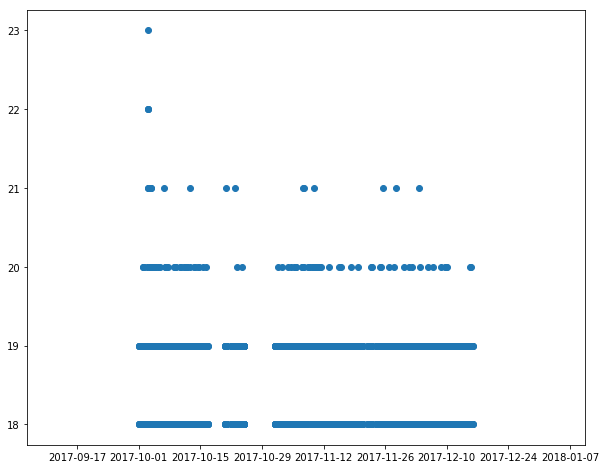

In [11]:
plt.scatter(ts.index, ts.values)

In [ ]:
import scipy.stats as scs
aa=scs.boxcox(ts.values) 

In [ ]:
aa

In [ ]:
plt.plot(np.arange(aa[0].shape[0]),aa[0])

In [ ]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
invboxcox(aa[0],-18.29705472956871)

In [ ]:
from scipy.stats.mstats import normaltest

In [ ]:
normaltest(ts.values)

In [ ]:
plt.plot(np.arange(len(res)),res)

In [ ]:
# grubbs.min_test_indices(ts, alpha=0.05)

In [ ]:
# grubbs.max_test_indices(ts, alpha=0.05)

In [ ]:
from PyAstronomy import pyasl

In [ ]:
outliers = pyasl.generalizedESD(ts, 40,alpha=0.05, fullOutput=True)[1]

In [ ]:
plt.figure(figsize=(17,9))
plt.plot(ts.index.values, ts.values)
plt.scatter(ts.index[outliers], ts.values[outliers],c='r')
plt.title('Показания, которые generalizedESD посчитал аномалией')
plt.ylabel('cpu')
plt.xlabel('Время')

# Фича от твиттера

In [ ]:
from pyculiarity import detect_ts

vals = df[df.ip=='10.10.245.12']['timestamp'].values/1000000
ts = pd.Series(data=df[df.ip=='10.10.245.12']['cpu'].values, index=vals)

test = pd.DataFrame()
test['timestamp'] = ts.index.values
test['count'] = ts.values

results = detect_ts(test, max_anoms=0.05, alpha=0.001, direction='both')

# format the twitter data nicely
test['timestamp'] = pd.to_datetime(test['timestamp'])
test.set_index('timestamp', drop=True)

# # make a nice plot

f, ax = plt.subplots(2, 1, sharex=True, figsize=(17,12))

# tmp_ts = pd.Series(np.zeros(test['timestamp'].shape[0], ))



ax[0].plot(test['timestamp'], test['count'], 'b')
ax[0].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax[0].set_title('Обнаружение аномалий')
ax[0].set_ylabel('cpu')

ax[1].set_xlabel('Время')
ax[1].plot(results['anoms'].index, results['anoms']['anoms'], 'b')
ax[1].set_ylabel('Величина аномалии')
plt.xticks(rotation=90)


In [12]:
from pykalman import KalmanFilter, UnscentedKalmanFilter

In [14]:
kf1 = KalmanFilter()
kf1 = kf1.em(ts, n_iter=1)
a1 = kf1.filter(ts)

# kf2 = UnscentedKalmanFilter()

# kf2 = kf2.em(ts, n_iter=2)
# a2 = kf2.filter(ts)


limit = 150
y = ts.values[10:limit]
l = len(y)
x = np.arange(l)
y1 = a1[0][10:limit]
# y2 = a2[0][10:limit]


# lbls = ts.index[10:limit]
# lbls = [datetime.fromtimestamp(lbls[0])]+['' for _ in range(len(lbls)-2)]+[datetime.fromtimestamp(lbls[-1])]

# plt.figure(figsize=(17,9))
# plt.grid(axis=0)
# plt.scatter(x,y, c='b')
# plt.plot(x,y1, c='g')
# plt.xticks(x, lbls);
# plt.ylabel('cpu');
# plt.xlabel('time');
# plt.title('Визуализация действия фильтра Калмана на зашумленном сигнале по параметру cpu на одном из ip')
# ax = plt.axes()        
# ax.yaxis.grid() # horizontal lines
# # ax.xaxis.grid() # vertical lines
# type(lbls[0])

kalman_ts = pd.Series(data=a1[0].flatten()[10:], index=ts.index.values[10:])

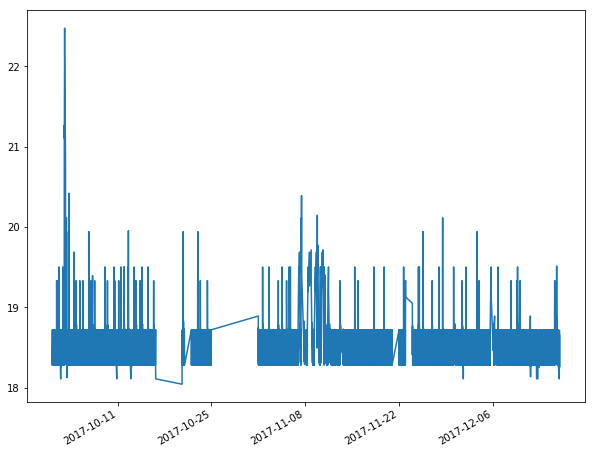

In [15]:
kalman_ts.plot()

In [ ]:
a1[0].flatten()

In [ ]:
aa = np.flatten(a1[0])

In [ ]:
plt.hist(ts.values);

In [17]:
from pyculiarity import detect_ts
ts = pd.Series(data=a1[0].flatten(), index=ts.index.values)

test = pd.DataFrame()
test['timestamp'] = ts.index.values
test['count'] = ts.values

results = detect_ts(test, max_anoms=0.05, alpha=0.001, direction='both')

# format the twitter data nicely
test['timestamp'] = pd.to_datetime(test['timestamp'])
test.set_index('timestamp', drop=True)

# # make a nice plot

f, ax = plt.subplots(2, 1, sharex=True, figsize=(25,15))

ax[0].plot(test['timestamp'], test['count'], 'b')
ax[0].plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax[0].set_title('Обнаружение аномалии')

ax[1].set_xlabel('Время')
ax[0].set_ylabel('cpu')
ax[1].plot(results['anoms'].index, results['anoms']['anoms'], 'b')
ax[1].set_ylabel('Величина аномалии')
plt.xticks(rotation=90)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 83))



ValueError: The input timestamp column must be a float or integer of the unix timestamp, not date
                                time columns, date strings or pd.TimeStamp columns.

In [ ]:
import concept_drift

In [18]:
# coeff , freq = pywt.cwt(ts.values, np.arange(1,100), 'gaus1')
coeff , freq = pywt.cwt(kalman_ts.values, np.arange(1,60), 'gaus1')

In [19]:
coeff.shape

(59, 4181)

In [22]:
from scipy import interpolate
y = np.arange(0,coeff.shape[0])
x = np.arange(0,coeff.shape[1])
xx, yy = np.meshgrid(x, y)
z = coeff
f = interpolate.interp2d(x, y, z, kind='cubic')

In [ ]:
# xnew = np.arange(0, coeff.shape[0], 0.1)
# ynew = np.arange(0,coeff.shape[1],0.1)
# znew = f(xnew, ynew)

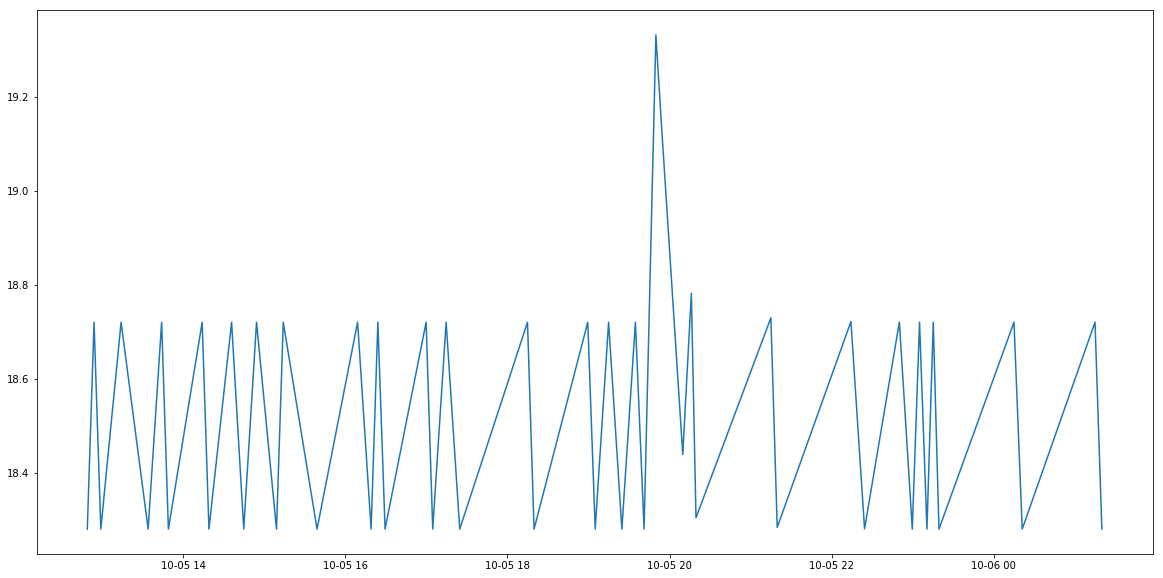

In [23]:
fig = plt.figure(figsize=(20,10))
plt.plot(kalman_ts.index.values[300:350],kalman_ts.values[300:350]);
plt.show()

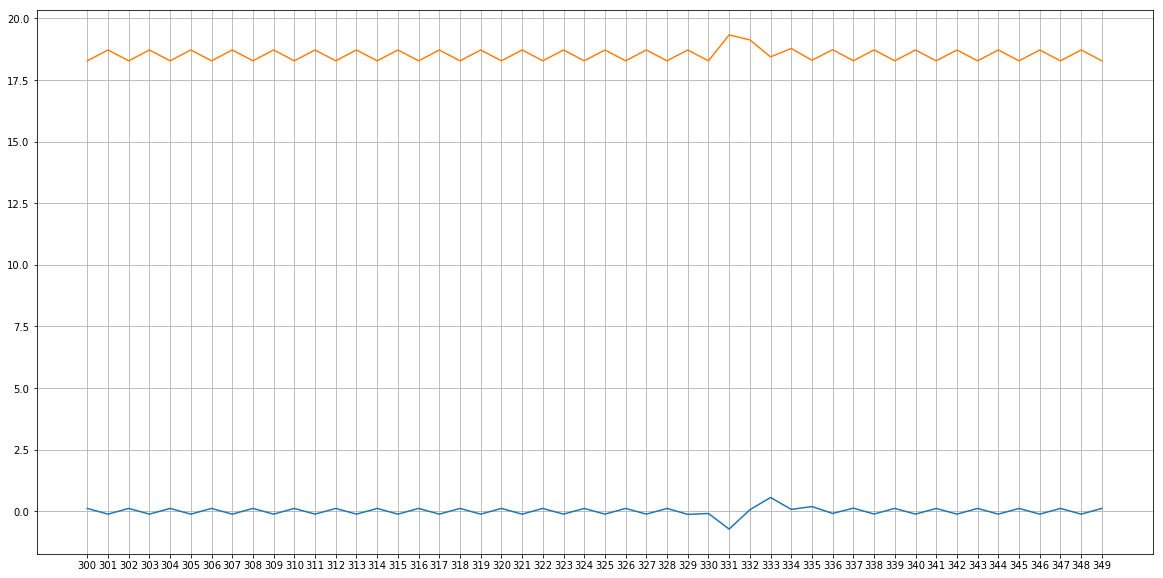

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(np.arange(300,350),z[0,300:350])
plt.plot(np.arange(300,350),kalman_ts.values[300:350]);
plt.xticks(np.arange(300,350));

In [28]:
coeff[:,1]

array([  -5.93301894,  -18.1663386 ,  -25.59245999,  -30.95105228,
        -35.55998937,  -39.36371111,  -42.77533463,  -45.97971498,
        -48.99201345,  -51.74513863,  -54.37556572,  -56.77162506,
        -59.21898727,  -61.5628668 ,  -63.73572087,  -65.92647311,
        -67.97569648,  -69.95741355,  -71.96985314,  -73.86739452,
        -75.67341372,  -77.49419206,  -79.34001924,  -81.07290333,
        -82.75210773,  -84.39458989,  -86.00268763,  -87.59361869,
        -89.13568241,  -90.78650342,  -92.27130969,  -93.76894194,
        -95.20291745,  -96.66120224,  -98.07088506,  -99.4283724 ,
       -100.8188768 , -102.16233777, -103.47634582, -104.88875446,
       -106.3143972 , -107.50067785, -108.88576424, -110.03954949,
       -111.30884092, -112.46513652, -113.73248382, -115.00342565,
       -116.18281203, -117.39257398, -118.53035815, -119.68436536,
       -120.89204575, -122.05362762, -123.1641831 , -124.28746585,
       -125.41297394, -126.45737034, -127.6478014 ])

In [29]:
x.shape

(4181,)

In [30]:
y.shape

(59,)

In [31]:
z.shape

(59, 4181)

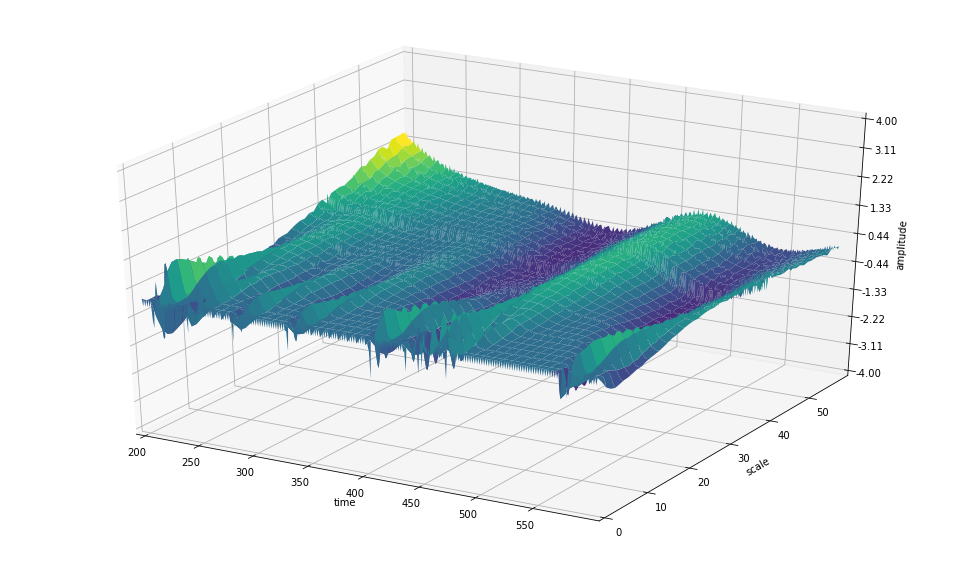

In [49]:
%matplotlib inline
# %matplotlib notebook
fig = plt.figure(figsize=(17,10))
ax = fig.gca(projection='3d')

rng = np.arange(200,600)
X, Y = np.meshgrid(x[rng], y)
Z = z[:,rng]

surf = ax.plot_surface(X,Y,Z, cmap='viridis',
                       linewidth=0)

# Customize the z axis.
ax.set_zlim(-4.001, 4.001)
ax.set_xlim(rng[0], rng[-1])
ax.set_ylim(0, 59)
ax.set_xlabel('time')
ax.set_ylabel('scale')
ax.set_zlabel('amplitude')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

In [91]:
kalman_ts.index[200]

Timestamp('2017-10-04 08:39:00.132780')

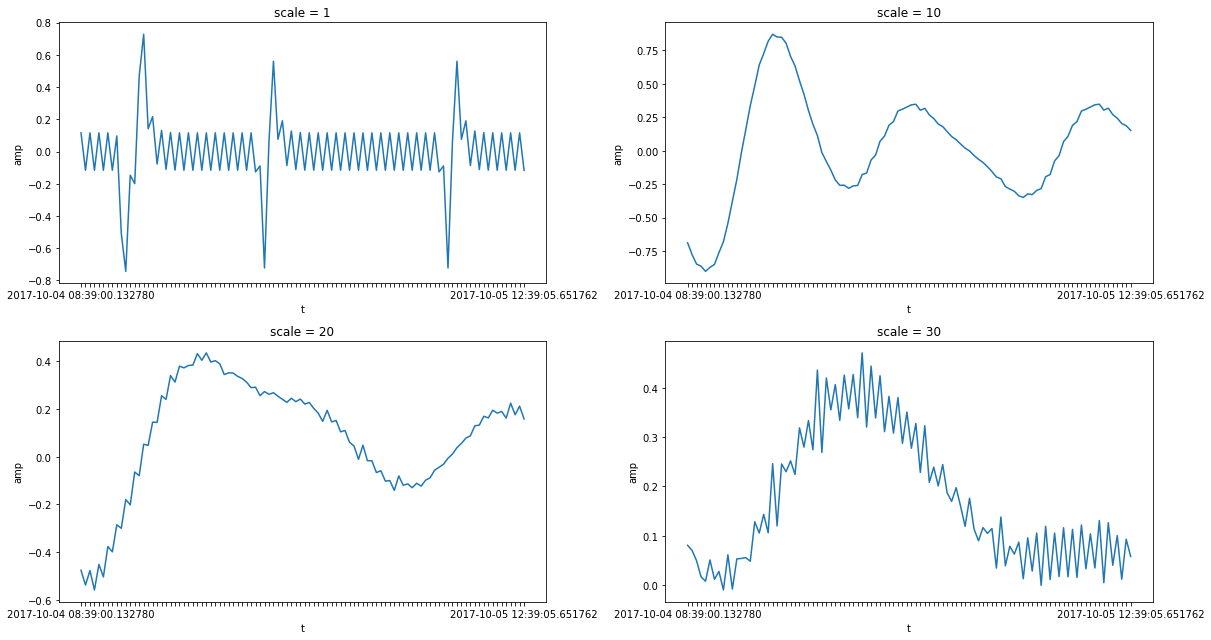

In [96]:
lbls = [kalman_ts.index[200]] + ['' for _ in np.arange(201,299)] + [kalman_ts.index[299]]

plt.figure(figsize=(17,9))
plt.subplot(221)
plt.plot(np.arange(z.shape[1])[200:300], z[0,200:300])
plt.title('scale = 1')
plt.xlabel('t')
plt.ylabel('amp')
plt.xticks(np.arange(200,300),lbls);

plt.subplot(222)
plt.plot(np.arange(z.shape[1])[200:300], z[10,200:300])
plt.title('scale = 10')
plt.xlabel('t')
plt.ylabel('amp')
plt.xticks(np.arange(200,300),lbls);

plt.subplot(223)
plt.plot(np.arange(z.shape[1])[200:300], z[20,200:300])
plt.title('scale = 20')
plt.xlabel('t')
plt.ylabel('amp')
plt.xticks(np.arange(200,300),lbls);

plt.subplot(224)
plt.plot(np.arange(z.shape[1])[200:300], z[30,200:300])
plt.title('scale = 30')
plt.xlabel('t')
plt.ylabel('amp')
plt.xticks(np.arange(200,300),lbls);
plt.tight_layout()


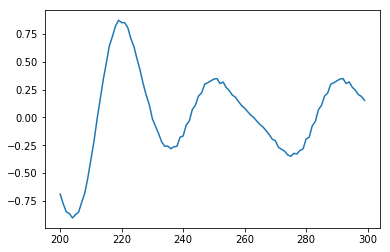

In [68]:
plt.plot(np.arange(z.shape[1])[200:300], z[10,200:300])

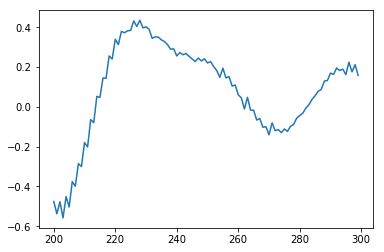

In [71]:
plt.plot(np.arange(z.shape[1])[200:300], z[20,200:300])

In [ ]:
%matplotlib inline
plt.figure(figsize=(17,9))
plt.matshow(coeff)
plt.xlabel('time')
plt.ylabel('scale')

In [ ]:
plt.matshow(coeff)
plt.xlabel('time')
plt.ylabel('scale')

In [ ]:
plt.imshow(coeff, extent=[-1, 1, 1, 11], cmap='PRGn', aspect='auto',vmax=abs(coeff).max(), vmin=-abs(coeff).max()) 
plt.xlabel('time')
plt.ylabel('scale')

In [ ]:
import pywt


x = np.linspace(0, 1, num=512)
data = np.sin(250 * np.pi * x**2)

wavelet = 'db2'
level = 4
order = "freq"  # other option is "normal"
interpolation = 'nearest'
cmap = plt.cm.cool

# Construct wavelet packet
wp = pywt.WaveletPacket(data, wavelet, 'symmetric', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = np.array([n.data for n in nodes], 'd')
values = abs(values)

# Show signal and wavelet packet coefficients
fig = plt.figure()
fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
ax = fig.add_subplot(2, 1, 1)
ax.set_title("linchirp signal")
ax.plot(x, data, 'b')
ax.set_xlim(0, x[-1])

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Wavelet packet coefficients at level %d" % level)
ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
          origin="lower", extent=[0, 1, 0, len(values)])
ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

# Show spectrogram and wavelet packet coefficients
fig2 = plt.figure()
ax2 = fig2.add_subplot(211)
ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
             interpolation='bilinear')
ax2.set_title("Spectrogram of signal")
ax3 = fig2.add_subplot(212)
ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
           interpolation='nearest')
ax3.set_title("Wavelet packet coefficients")

In [ ]:
coef.shape

In [ ]:
coef, freqs = cwt(np.asarray(x), np.arange(10), wavelet='gaus1')

In [ ]:
frq, tm, Sxx = scipy.signal.spectrogram(ts.values[:], fs=10.0, nperseg=41, noverlap=16)
f, ax = plt.subplots(figsize=(8, 4))
ax.pcolormesh(tm, frq, 10 * np.log10(Sxx), cmap='viridis')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]');

In [ ]:
rate = 30.0 
t = np.arange(0, 10, 1/rate) 
x = np.sin(2*np.pi*4*t) + np.sin(2*np.pi*7*t) + np.random.randn(len(t))*0.2 + (t/2)**2
plt.plot(t,x)

In [ ]:
from scipy.optimize import minimize

In [ ]:
def wrapper_for_functional(t,y):
    w = []
    for ix in range(len(t)):
        if ix == 0:
            new_w = t[ix+1] - t[ix]
        elif ix == len(t)-1:
            new_w = t[len(t)-1]-t[len(t)-2]
        else:
            new_w = t[ix+1] - t[ix-1]
        w.append(new_w)
        
    def functional(a):
        return sum([(yy - a[0] - a[1]*tt - a[2]*tt**2)**2 * ww for yy, tt, ww in zip(y,t,w)])
    
    return functional
    

In [ ]:
res = minimize(wrapper_for_functional(t, x), (1,1,1), method='Nelder-Mead')

In [ ]:
res.x

In [ ]:
y_pred = [res.x[0] + res.x[1]*tt + res.x[2]*tt**2 for tt in t]

In [ ]:
plt.plot(t,x)
plt.plot(t,y_pred)
plt.plot(t, np.asarray(x)- np.asarray(y_pred))